In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import numpy.random as rand
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import time

In [5]:
def alert():
    winsound.Beep(600,700)

# Importing Data

The data used in this project form 16 clusters, as shown in the picture below. The points in red show the positions of the 16 centroids corresponding to the (global) optmial solution.

In [8]:
dadosX = pd.read_csv('dadosX16.csv')
dadosY = pd.read_csv('dadosY16.csv')
X = np.array(dadosX[['X0','X1']]).T #data coordinates
Ygab = np.array(dadosY[['Ygab0','Ygab1']]).T #centroids coordinates that represent the solution to the problem
Nc = np.shape(Ygab)[1]
n_clusters = np.shape(Ygab)[1]

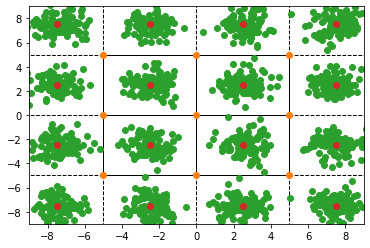

In [9]:
vor = Voronoi(Ygab.T)
fig = voronoi_plot_2d(vor)
plt.plot(X[0,:],X[1,:],'o')
plt.plot(Ygab[0,:],Ygab[1,:],'o')
plt.show()

J_original is the cost function used for the SA. For the ES, we use J = -J_original as fitness function. We do this because ES works by maximizing the fitness function, as opposed to the SA, that minimizes the cost function.

In [10]:
def J_original(Y,p=0):
    M,N = np.shape(X); M,K = np.shape(Y) #matrix dimensions
    d = np.zeros((K,N)) #KxN matrix that stores the quadratic distances
    for j in range(K):
        Yj = np.reshape(Y[:,j], [2,1]) #mere formality required so the we can transform Yj into column matrix
        # each row j of d represents the quadratic distanc of the centroid j
        #para os N pontos de X
        d[j,:] = np.sum((X-Yj)**2,axis=0)
    d_min = np.min(d,axis=0) # vector of size N containing the smallest d's for each point of X
    cell_counts = np.sum(d == d_min,axis=1) #count of points in each cell (centroid)
    n_empty_cells = np.sum(cell_counts == 0)
    
    return np.sum(d_min)/N + 50*n_empty_cells

print("Jmin = ", J_original(Ygab))

J = lambda Y,p=0: -J_original(Y,p=0)

Jmin =  0.9784967724680637


# Metrics

Below, we define the metrics that will be used to evaluate the performance of the SA an ES algorithms, namely, the success rate (SR), the mean best fitness (MBF) and the average number of evaluations (calls) of the cost/fitness function to the solution (AES).

In [11]:
def isSuccess(Y):
    '''Determines if the solution is a global optimum given the list of centroids Y'''
    M,K = np.shape(Ygab) #dimensions of the matrix containing the centroids
    d = np.zeros((K,K)) #KxN matrix that stores the quadratic distances
    for j in range(K): #mere formality required so that we can transform Yj into a column matrix
        Yj = np.reshape(Y[:,j], [2,1])
        #each row j of d represents the quadratic distanc of the centroid j
        #para os N pontos de X
        d[j,:] = np.sum((Ygab-Yj)**2,axis=0)
    d_min = np.min(d,axis=0) # vector of size N containing the smallest d's for each point of X
    cell_counts = np.sum(d == d_min,axis=1) #count of points in each cell (centroid)
    n_empty_cells = np.sum(cell_counts == 0)
    
    if n_empty_cells == 0:
        return 1
    else:
        return 0

In [12]:
def SR(Y_hist):
    '''Success Rate'''
    sucessos = 0
    for y in Y_hist:
        Y = np.reshape(y, [2,n_clusters])
        if isSuccess(Y):
            sucessos += 1
    return sucessos/len(Y_hist)

def MBF(J_hist):
    '''Mean Best Fitness'''
    return np.mean(J_hist)

def AES_es(Y_hist, n_sons):
    '''Average number of evaluations of the cost function to solution (global optimum) (for the ES)'''
    calls = 0
    sucs = 0
    for k in range(np.shape(Y_hist)[0]):
        for i in range(np.shape(Y_hist)[1]):
            Y = np.reshape(Y_hist[k][i], [2, n_clusters])
            if isSuccess(Y):
                calls += (i+1)*n_sons
                break
        sucs += 1
    return int(calls/sucs)

def AES_sa(Y_hist, max_iter):
    '''Average number of evaluations of the cost function to solution (global optimum) (for the SA)'''
    calls = 0
    sucs = 0
    for k in range(np.shape(Y_hist)[0]):
        for i in range(np.shape(Y_hist)[1]):
            if isSuccess(Y_hist[k][i]):
                calls += (i+1)*max_iter
                break
        sucs += 1
    return int(calls/sucs)

# SA

Here, we evaluate the performance of the SA algorithm. The parameters are shown below.

In [13]:
n_max_eval = 60e3 #maximum number of evaluations of the cost function allowed
max_iter = int(1e2); n_rep = 100; eps = 0.3; T0 = 0.1; T = T0;
nmax_T = int(n_max_eval/max_iter);

In [153]:
#n_rep: number of repetitions (redundancy)
#max_iter: number of iterations per temperature
#nmax_T: number of temperatures
#eps: epsilon
#T0: initial temperature
t0 = time.time(); Y_hist_sa = []; histJ_sa = []
for rep in tqdm(range(n_rep)):
    Y_hist_sa_aux = []
    Y = rand.normal(0,1,size=(2,Nc))
    histJ_sa_aux = [J_original(Y)]
    for k in range(nmax_T):
        for i in range(max_iter):
            Yn = Y + eps*rand.normal(0,1,size=(2,Nc)) #adding the perturbation to the solution
            Jyn = J_original(Yn)
            Jy = histJ_sa_aux[-1]
            if rand.uniform(0,1) < np.exp(-(Jyn - Jy)/T):
                Y = Yn
                histJ_sa_aux.append(Jyn)
            else:
                histJ_sa_aux.append(Jy)
        Y_hist_sa_aux.append(Y)
        T = T0/np.log(k + 3)
    histJ_sa.append(histJ_sa_aux)
    Y_hist_sa.append(Y_hist_sa_aux)

tempo_total_sa = time.time() - t0
alert()

  1%|▊                                                                               | 1/100 [00:40<1:07:27, 40.88s/it]<ipython-input-153-3b1bf71f2f3c>:15: RuntimeWarning: overflow encountered in exp
  if rand.uniform(0,1) < np.exp(-(Jyn - Jy)/T):
100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:03:33<00:00, 38.13s/it]


We see the results below:

In [154]:
list_bestYs_sa = [Y_hist_sa[i][-1][:][:] for i in range(n_rep)]

#mean time
tempo_medio = tempo_total_sa/n_rep
minutos = np.floor(tempo_medio/60)
segundos = tempo_medio - minutos*60

print("Limit:",int(n_max_eval),"calls","|","K: ", nmax_T,"|","N:",max_iter,"|",
      "Mean time:", "%d:%d"%(int(minutos),int(segundos)), "|", "Repetitions:", n_rep)

aes_sa = AES_sa(Y_hist_sa, max_iter)
print("SR:", SR(list_bestYs_sa))
print("MBF:", MBF(np.array(histJ_sa)[:,-1]))
print("AES:",aes_sa, "calls/iterations =", int(aes_sa/max_iter), "temperatures")

Limite: 60000 chamadas | K:  600 | N: 100 | Tempo médio: 0:38 | Repetições: 100
SR: 1.0
MBF: 1.2175876602188993
AES: 4295 chamadas/iterações = 42 temperaturas


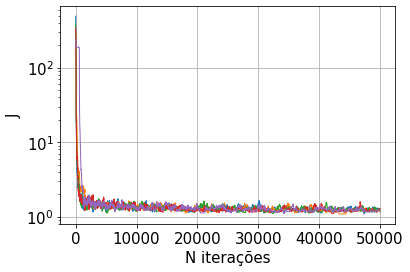

In [151]:
plt.rcParams.update({'font.size': 15})
for curva in histJ_sa:
    plt.semilogy(curva, linewidth=1)
plt.ylabel('J')
plt.xlabel('N iterações')
plt.grid()
plt.show()

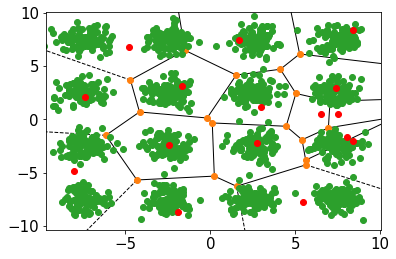

In [52]:
ind_rep = 0
#vor = Voronoi(y.T)
vor = Voronoi(list_bestYs_sa[ind_rep].T)
fig = voronoi_plot_2d(vor)
plt.plot(X[0,:],X[1,:],'o')
plt.plot(list_bestYs_sa[ind_rep][0,:],list_bestYs_sa[ind_rep][1,:],'ro')
#plt.plot(y[0,:],y[1,:],'ro')
plt.show()

# Evolutionary Strategy - (mu, lambda)

In [140]:
n_max_eval = 50e3
n_clusters = np.shape(Ygab)[1]
n_vars = 2*n_clusters; pop_size = 60; n_sons = 7*pop_size
n_gens = int(n_max_eval/n_sons)
tau1 = (1)*1/np.sqrt(2*n_vars) #related to the individual
tau2 = (1)*1/np.sqrt(2*np.sqrt(n_vars)) #related to the entry
n_rep = 5
aux_list = range(0,n_vars)

In [14]:
def crossover_all(Pop_vars,Pop_str):
    '''Performs intermediate crossover of the strategy genes and discrete crossover of the x genes'''
    indexes = rand.randint(0,pop_size,[n_sons,2])
    for k in range(n_sons):
        ind0 = indexes[k,0]; ind1 = indexes[k,1]
        rand_vars1 = rand.randint(0,2,[1,n_vars])
        rand_vars2 = np.mod(rand_vars1 + 1,2)
        Sons_str[k,:] = (Pop_str[ind0,:] + Pop_str[ind1,:])/2
        Sons_vars[k,:] = rand_vars1*Pop_vars[ind0,:] + rand_vars2*Pop_vars[ind1,:]
    return (Sons_vars, Sons_str)
    
def crossover_ncross(Pop_vars, Pop_str, n_cross):
    '''Performs intermediate crossover of the strategy genes and discrete crossover of the x genes in n_cross random
    position'''
    indexes = rand.randint(0,pop_size,[n_sons,2])
    for k in range(n_sons):
        ind0 = indexes[k,0]; ind1 = indexes[k,1]
        rand_indexes_x = rand.choice(aux_list,n_cross,replace=False)
        Sons_str[k,:] = (Pop_str[ind0,:] + Pop_str[ind1,:])/2
        Sons_vars[k,:] = Pop_vars[ind0,:]
        Sons_vars[k,rand_indexes_x] = Pop_vars[ind1,rand_indexes_x]
    return (Sons_vars, Sons_str)

    
def crossover_inter_2_sons(Pop_vars, Pop_str, n_cross, a = [0.5, 0.5]):
    '''
    Performs crossover of the strategy genes and the x genes independently
    n_cross: list containing the number of genes at the end of strategy and x cromossomes, respectively, that
    will undergo crossover
    a: list containing the weights for each strategy and x cromossomes, respectively
    '''
    Sons_vars = np.zeros([n_sons,n_vars]); Sons_str  = np.zeros([n_sons,n_vars])
    a_vars, a_str = a
    b_vars = 1 - a_vars; b_str  = 1 - a_str; n_cross_vars, n_cross_str = n_cross
    indexes = rand.randint(0,pop_size,[int((n_sons)/2),2])
    for k in range(int(n_sons/2)):
        ind0 = indexes[k,0]; ind1 = indexes[k,1]
        Sons_str[2*k,:] = np.concatenate([Pop_str[ind0,0:n_vars-n_cross_str],
                                    a_str*Pop_str[ind0,n_vars-n_cross_str:] + b_str*Pop_str[ind1,n_vars-n_cross_str:]])
        Sons_str[2*k+1,:] = np.concatenate([Pop_str[ind1,0:n_vars-n_cross_str],
                                    b_str*Pop_str[ind0,n_vars-n_cross_str:] + a_str*Pop_str[ind1,n_vars-n_cross_str:]])
        Sons_vars[2*k,:] = np.concatenate([Pop_vars[ind0,0:n_vars-n_cross_vars],
                                    a_vars*Pop_vars[ind0,n_vars-n_cross_vars:] + b_vars*Pop_vars[ind1,n_vars-n_cross_vars:]])
        Sons_vars[2*k+1,:] = np.concatenate([Pop_vars[ind1,0:n_vars-n_cross_vars],
                                    b_vars*Pop_vars[ind0,n_vars-n_cross_vars:] + a_vars*Pop_vars[ind1,n_vars-n_cross_vars:]])
        
    return (Sons_vars, Sons_str)
    

def crossover_inter_1_son(Pop_vars, Pop_str, n_cross, a = [0.5, 0.5]):
    '''
    Performs crossover of the strategy genes and the x genes independently
    n_cross: list containing the number of genes at the end of strategy and x cromossomes, respectively, that
    will undergo crossover
    a: list containing the weights for each strategy and x cromossomes, respectively
    '''
    Sons_vars = np.zeros([n_sons,n_vars]); Sons_str  = np.zeros([n_sons,n_vars])
    indexes = rand.randint(0,pop_size,[n_sons,2])
    n_cross_vars, n_cross_str = n_cross
    a_vars, a_str = a
    b_vars = 1 - a_vars
    b_str  = 1 - a_str
    for k in range(n_sons):
        ind0 = indexes[k,0]; ind1 = indexes[k,1]
        Sons_str[k,:] = np.concatenate([Pop_str[ind0,0:n_vars-n_cross_str],
                                a_str*Pop_str[ind0,n_vars-n_cross_str:] + b_str*Pop_str[ind1,n_vars-n_cross_str:]])
        Sons_vars[k,:] = np.concatenate([Pop_vars[ind0,0:n_vars-n_cross_vars],
                                a_vars*Pop_vars[ind0,n_vars-n_cross_vars:] + b_vars*Pop_vars[ind1,n_vars-n_cross_vars:]])
    return (Sons_vars, Sons_str)

def crossover_partial(Pop_vars, Pop_str):
    '''Performs intermediate crossover only of the stratety genes'''
    Sons_vars = np.zeros([n_sons,n_vars]); Sons_str  = np.zeros([n_sons,n_vars])
    indexes = rand.randint(0,pop_size,[n_sons,2])
    for k in range(n_sons):
        ind0 = indexes[k,0]; ind1 = indexes[k,1]
        Sons_str[k,:] = (Pop_str[ind0,:] + Pop_str[ind1,:])/2
        aux_list = [Pop_vars[ind0,:], Pop_vars[ind1,:]]
        Sons_vars[k,:] = aux_list[rand.randint(0,2)]
    return (Sons_vars, Sons_str)

In [2]:
J_hist_es = []
Y_hist_es = []
t0 = time.time()
#for i in range(n_rep):
for i in tqdm(range(n_rep)):
#Initialization
    best_Js = []
    best_Ys = []
    Pop_vars = rand.normal(0,2,[pop_size,n_vars])
    Pop_str = rand.uniform(0,1,[pop_size,n_vars])
    #for ii in tqdm(range(n_gens)):
    for ii in range(n_gens):
        #Crossover
        #(Sons_vars, Sons_str) = crossover_inter_2_sons(Pop_vars, Pop_str, [0,32], a = [0.5, 0.5])
        (Sons_vars, Sons_str) = crossover_partial(Pop_vars, Pop_str)
        #Mutation
        mut_fact1 = np.exp(tau1*rand.normal(0,1,[n_sons,1]))
        mut_fact2 = np.exp(tau2*rand.normal(0,1,[n_sons,n_vars]))
        Sons_str = Sons_str * mut_fact1 * mut_fact2

        Sons_vars += Sons_str*rand.normal(0,1,[n_sons,n_vars])

        #Survivors selection
        J_sons = np.zeros([1,n_sons])
        for k in range(n_sons):
            J_sons[0,k] = J(np.reshape(Sons_vars[k,:],[2,n_clusters]))
            

        indexes = np.array(range(n_sons))
        tuples = sorted(zip(J_sons[0],indexes))[n_sons-pop_size:]
        sorted_indexes = np.array(tuples,dtype=int)[:,1]

        Pop_vars = Sons_vars[sorted_indexes]
        Pop_str  = Sons_str[sorted_indexes]

        best_Js.append(-tuples[-1][0])
        best_Ys.append(Pop_vars[-1,:])
    Y_hist_es.append(best_Ys)
    J_hist_es.append(best_Js)
tempo_total_es = time.time() - t0
alert()

NameError: name 'time' is not defined

In [146]:
list_bestYs = [Y_hist_es[i][-1][:] for i in range(n_rep)]

#tempo medio
tempo_medio = tempo_total_es/n_rep
minutos = np.floor(tempo_medio/60)
segundos = tempo_medio - minutos*60

print("Limit:",int(n_max_eval),"call","|","Generations: ", n_gens,"|","Population:",pop_size,"|","Sons:",n_sons, "|",
      "Mean time:", "%d:%d"%(int(minutos),int(segundos)))

aes = AES_es(Y_hist_es, n_sons)
print("SR:", SR(list_bestYs))
print("MBF:", MBF(np.array(J_hist_es)[:,-1]))
print("AES:",aes, "generations =", int(aes/n_sons), "generations")

Limite: 50000 chamadas | Gerações:  119 | População: 60 | Filhos: 420 | Tempo médio: 0:29
SR: 1.0
MBF: 0.9804155910127929
AES: 11676 chamadas = 27 gerações


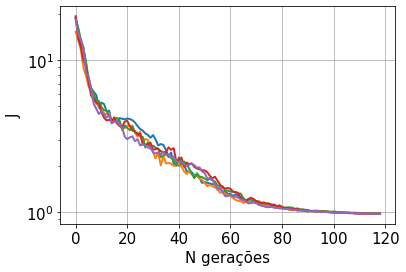

In [147]:
plt.rcParams.update({'font.size': 15})
for curva in J_hist_es:
    plt.semilogy(curva, linewidth=2)
plt.ylabel('J')
plt.xlabel('N generations')
plt.grid()
plt.show()

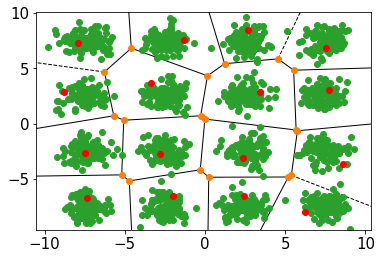

In [402]:
Y = np.reshape(list_bestYs[i],[2,n_clusters])
vor = Voronoi(Y.T)
fig = voronoi_plot_2d(vor)
plt.plot(X[0,:],X[1,:],'o')
plt.plot(Y[0,:],Y[1,:],'ro')
plt.show()
i += 1

# Evolutionary Strategy - (mu + lambda)

In [169]:
#Faltou implementar o limiar epsilon
n_max_eval = 150e3
n_clusters = np.shape(Ygab)[1]
n_vars = 2*n_clusters; pop_size = 60; n_sons = 7*pop_size
n_gens = int(n_max_eval/n_sons)
tau1 = (7)*1/np.sqrt(2*n_vars) #associada ao individuo
tau2 = (7)*1/np.sqrt(2*np.sqrt(n_vars)) #associada a cada entrada
n_rep = 2
aux_list = range(0,n_vars)

In [170]:
J_hist_es = []
Y_hist_es = []
t0 = time.time()
#for i in range(n_rep):
for i in tqdm(range(n_rep)):
#Initialization
    best_Js = []
    best_Ys = []
    Pop_vars = rand.normal(0,2,[pop_size,n_vars])
    Pop_str = rand.uniform(0,1,[pop_size,n_vars])
    
    J_parents = np.zeros([1,pop_size])
    for k in range(pop_size):
        J_parents[0,k] = J(np.reshape(Pop_vars[k,:],[2,n_clusters]))
        
    #for ii in tqdm(range(n_gens)):
    for ii in range(n_gens):
        #Selection
        Sons_vars = np.zeros([n_sons,n_vars])
        Sons_str  = np.zeros([n_sons,n_vars])
        #Crossover
        (Sons_vars, Sons_str) = crossover_partial(Pop_vars, Pop_str)
        #Mutation
        mut_fact1 = np.exp(tau1*rand.normal(0,1,[n_sons,1]))
        mut_fact2 = np.exp(tau2*rand.normal(0,1,[n_sons,n_vars]))
        Sons_str = Sons_str * mut_fact1 * mut_fact2

        Sons_vars += Sons_str*rand.normal(0,1,[n_sons,n_vars])

        #Survivors selection
        J_sons = np.zeros([1,n_sons])
        for k in range(n_sons):
            J_sons[0,k] = J(np.reshape(Sons_vars[k,:],[2,n_clusters]))
        J_total = np.concatenate([J_parents, J_sons], axis = 1)

        indexes = np.array(range(pop_size + n_sons))
        tuples = sorted(zip(J_total[0],indexes))[n_sons:]
        sorted_indexes = np.array(tuples,dtype=int)[:,1]
        J_parents = np.reshape(np.array(tuples)[:,0],[1, pop_size])
    
        Pop_vars = np.concatenate([Pop_vars, Sons_vars])[sorted_indexes]
        Pop_str  = np.concatenate([Pop_vars, Sons_vars])[sorted_indexes]

        best_Js.append(-tuples[-1][0])
        best_Ys.append(Pop_vars[-1,:])
    Y_hist_es.append(best_Ys)
    J_hist_es.append(best_Js)
tempo_total_es = time.time() - t0
alert()

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [05:11<00:00, 155.82s/it]


In [171]:
list_bestYs = [Y_hist_es[i][-1][:] for i in range(n_rep)]

#mean time
tempo_medio = tempo_total_es/n_rep
minutos = np.floor(tempo_medio/60)
segundos = tempo_medio - minutos*60

print("Limit:",int(n_max_eval),"calls","|","Generations: ", n_gens,"|","Population:",pop_size,"|","Sons:",n_sons, "|",
      "Mean time:", "%d:%d"%(int(minutos),int(segundos)))

aes = AES_es(Y_hist_es, n_sons)
print("SR:", SR(list_bestYs))
print("MBF:", MBF(np.array(J_hist_es)[:,-1]))
print("AES:",aes, "calls =", int(aes/n_sons), "generations")

Limite: 150000 chamadas | Gerações:  357 | População: 60 | Filhos: 420 | Tempo médio: 2:35
SR: 0.0
MBF: 4.358297621842503
AES: 0 chamadas = 0 gerações


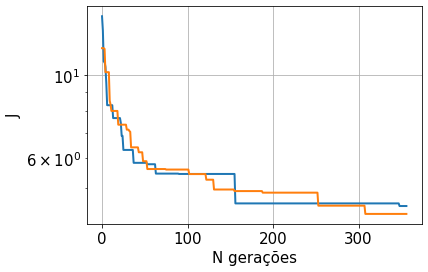

In [172]:
plt.rcParams.update({'font.size': 15})
for curva in J_hist_es:
    plt.semilogy(curva, linewidth=2)
plt.ylabel('J')
plt.xlabel('N generations')
plt.grid()
plt.show()

In [ ]:
Y = np.reshape(list_bestYs[0],[2,n_clusters])
#Y = np.reshape(Y_hist_recomb[0],[2,n_clusters])
vor = Voronoi(Y.T)
fig = voronoi_plot_2d(vor)
plt.plot(X[0,:],X[1,:],'o')
plt.plot(Y[0,:],Y[1,:],'ro')
plt.show()